## Initial setup

In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.1


In [2]:
# !pip install wandb
import wandb
import os
os.environ['WANDB_DISABLE_CODE'] = 'True'
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['WANDB_NOTEBOOK_NAME']= 'Experiments'
os.environ['WANDB_DISABLE_CODE'] = 'True'
wandb.login()

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Currently logged in as: rlrahulkanojia-hp (use `wandb login --relogin` to force relogin)


True

In [3]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import losses
import random
import cv2
from imutils import paths
tf.random.set_seed(666)
np.random.seed(666)



In [4]:

# Set of Expermimentss

# Datasets
#    1 Imagenet - 5
#    2 Cifar-10
#    3 FacesEmore - 5 
#    4 Custom - 5
    
# Losses 
#    1 Triplet loss
#    2 Max_Margin_Loss
#    3 NXTENT Loss

# Distances
#    0 None (Triplet Loss)
#    1 Cosine
#    2 Euclidian

# Models
#    0 Resnet Scratch
#    1 Facenet Pretrained

#### Datasets


##### Imagenet

In [ ]:
# Train and test image paths
train_images = list(paths.list_images("Data/imagenet-5-categories/train"))
test_images = list(paths.list_images("Data/imagenet-5-categories/test"))


In [ ]:
def prepare_images(image_paths):
    images = []
    labels = []

    for image in tqdm(image_paths):
        image_pixels = plt.imread(image)
        image_pixels = cv2.resize(image_pixels, (128,128))
        image_pixels = image_pixels/255.

        label = image.split("/")[3].split("_")[0]

        images.append(image_pixels)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    print(images.shape, labels.shape)

    return images, labels

##### Cifar 10

In [ ]:
train_images = list(paths.list_images("Data/cifar10/train"))
test_images = list(paths.list_images("Data/cifar10/test"))

In [ ]:
def prepare_images(image_paths):
    images = []
    labels = []

    for image in tqdm(image_paths):
        image_pixels = plt.imread(image)
        image_pixels = cv2.resize(image_pixels, (128,128))
        image_pixels = image_pixels/255.

        label = image.split("/")[3]

        images.append(image_pixels)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    print(images.shape, labels.shape)

    return images, labels

##### Facesemore

In [5]:
train_images = list(paths.list_images("Data/Facesemore/"))
test_images = list(paths.list_images("Data/Facesemore/"))

In [6]:
def prepare_images(image_paths):
    images = []
    labels = []

    for image in tqdm(image_paths):
        image_pixels = plt.imread(image)
        image_pixels = cv2.resize(image_pixels, (128,128))
        image_pixels = image_pixels/255.

        label = image.split("/")[2]

        images.append(image_pixels)
        labels.append(label)
        
    temp = list(zip(images, labels)) 
    random.shuffle(temp) 
    images, labels = zip(*temp) 

    images = np.array(images)
    labels = np.array(labels)

    print(images.shape, labels.shape)

    return images, labels

#### Dataloader

In [7]:

X_train, y_train = prepare_images(train_images)
X_test, y_test = prepare_images(test_images)


(319, 128, 128, 3) (319,)



(319, 128, 128, 3) (319,)


In [8]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)


In [9]:
y_train

array(['32', '32', '9234', '9234', '10', '11', '11', '32', '22', '32',
       '11', '9234', '11', '11', '11', '10', '11', '32', '11', '10',
       '9234', '11', '32', '10', '32', '10', '32', '11', '32', '11',
       '9234', '11', '22', '11', '11', '22', '22', '32', '11', '32', '11',
       '32', '11', '11', '11', '11', '22', '10', '10', '11', '11', '32',
       '10', '22', '10', '22', '10', '11', '22', '32', '11', '32', '11',
       '10', '32', '10', '11', '10', '32', '10', '32', '32', '32', '22',
       '10', '11', '9234', '11', '22', '32', '32', '10', '32', '22', '11',
       '32', '22', '11', '10', '32', '32', '11', '11', '9234', '10', '10',
       '9234', '32', '10', '9234', '32', '10', '10', '11', '11', '10',
       '32', '10', '32', '11', '11', '9234', '10', '10', '22', '11', '10',
       '9234', '10', '11', '10', '22', '22', '32', '22', '11', '11', '22',
       '32', '32', '22', '10', '11', '11', '10', '22', '11', '10', '11',
       '10', '11', '22', '11', '10', '10', '11', '11'

In [10]:
train_ds=tf.data.Dataset.from_tensor_slices((X_train,y_train_enc))
validation_ds=tf.data.Dataset.from_tensor_slices((X_test,y_test_enc))

In [11]:
IMG_SHAPE = 128
BS = 128#64
AUTO = tf.data.experimental.AUTOTUNE
train_ds = (
    train_ds
    .shuffle(100)
    .batch(BS)
    .prefetch(AUTO))
validation_ds = (
    validation_ds
    .shuffle(100)
    .batch(BS)
    .prefetch(AUTO))

## Model building

In [12]:
# Reference: https://github.com/wangz10/contrastive_loss/blob/master/model.py
class UnitNormLayer(tf.keras.layers.Layer):
    '''Normalize vectors (euclidean norm) in batch to unit hypersphere.
    '''
    def __init__(self):
        super(UnitNormLayer, self).__init__()

    def call(self, input_tensor):
        norm = tf.norm(input_tensor, axis=1)
        return input_tensor / tf.reshape(norm, [-1, 1])

In [13]:
# Encoder Network
def encoder_net():
	inputs = Input((IMG_SHAPE, IMG_SHAPE, 3))
	normalization_layer = UnitNormLayer()

	encoder = tf.keras.applications.ResNet50(weights=None, include_top=False)
	encoder.trainable = True

	embeddings = encoder(inputs, training=True)
	embeddings = GlobalAveragePooling2D()(embeddings)
	norm_embeddings = normalization_layer(embeddings)

	encoder_network = Model(inputs, norm_embeddings)

	return encoder_network

# Projector Network
def projector_net():
	projector = tf.keras.models.Sequential([
        Dense(2048, activation="relu"),
		Dense(256, activation="relu"),
		UnitNormLayer()
	])

	return projector

In [14]:
#SGD with lr decay function
decay_steps = 1000
lr_decayed_fn = tf.keras.experimental.CosineDecay(
    initial_learning_rate=0.05, decay_steps=decay_steps)
optimizer = tf.keras.optimizers.RMSprop(lr_decayed_fn)

In [15]:
encoder_r = encoder_net()
projector_z = projector_net()

@tf.function
def train_step(images, labels):
	with tf.GradientTape() as tape:
		r = encoder_r(images, training=True)
		z = projector_z(r, training=True)
		loss = losses.supervised_nt_xent_loss(z, labels, temperature=0.07, base_temperature=0.07 )

	gradients = tape.gradient(loss, 
		encoder_r.trainable_variables + projector_z.trainable_variables)
	optimizer.apply_gradients(zip(gradients, 
		encoder_r.trainable_variables + projector_z.trainable_variables))

	return loss

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


supervised_contrastive_loss,3.08711
_step,200
_runtime,190
_timestamp,1607428118
training_time,187.6824


supervised_contrastive_loss,██████████████▇█▆▅▅▅▅▇▄▄▅▄▄▃▃▃▂▂▁▁▁▁▁▁▁▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
training_time,▁


wandb: wandb version 0.10.12 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch: 200 Loss: 3.069
Epoch: 210 Loss: 3.056
Epoch: 220 Loss: 3.076
Epoch: 230 Loss: 3.093
Epoch: 240 Loss: 3.053
Epoch: 250 Loss: 3.056
Epoch: 260 Loss: 3.043
Epoch: 270 Loss: 3.043
Epoch: 280 Loss: 3.096
Epoch: 290 Loss: 3.055



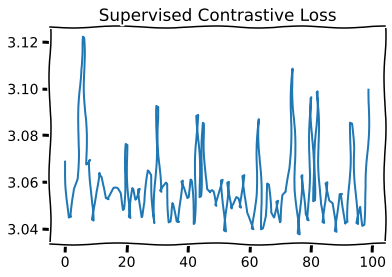

In [17]:
import time

wandb.init(project="Experiments",id='Facesemore_sup_nt_euclidean_Resnet_')
EPOCHS = 300
LOG_EVERY = 10
train_loss_results = []

start = time.time()
for epoch in tqdm(range(200,EPOCHS)):	
	epoch_loss_avg = tf.keras.metrics.Mean()
	
	for (images, labels) in train_ds:
		loss = train_step(images, labels)
		epoch_loss_avg.update_state(loss) 

	train_loss_results.append(epoch_loss_avg.result())
	wandb.log({"supervised_contrastive_loss": epoch_loss_avg.result()})

	if epoch % LOG_EVERY == 0:
		print("Epoch: {} Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))

end = time.time()
wandb.log({"training_time": end - start})

with plt.xkcd():
    plt.plot(train_loss_results)
    plt.title("Supervised Contrastive Loss")
    plt.show()

/home/rahulkanojia/envs/tf/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


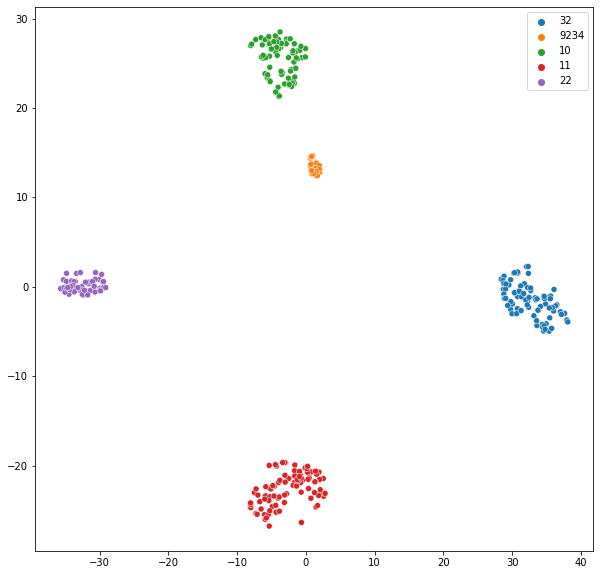

In [18]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
def plot_embeddings(emb,labels):
  tl=TSNE()
  embedding=tl.fit_transform(emb)
  fig = plt.figure(figsize = (10, 10))
  sns.scatterplot(embedding[:,0], embedding[:,1], hue=labels)
  plt.show()

  return fig

encoded_vector=encoder_r.predict(X_train)
fig = plot_embeddings(encoded_vector,y_train)

In [20]:
wandb.log(({"plotting encoded vectors of facesemore contrastive loss": wandb.Image(fig)}))